<a href="https://colab.research.google.com/github/AndrewArnett/DS-Unit-2-Applied-Modeling/blob/master/U2_S3_assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [ ]:
!pip install pandas-profiling==2.*
!pip install category_encoders==2.*

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.



In [4]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, minimal=True).to_notebook_iframe()

profile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### I have a classification problem, it is distributed as a True/False on whether or not a purchase was made.  The target is imbalanced, with a baseline of 84.5% False.  I will probably be using an F1 score as my evaluation metric.

In [5]:
df['Returning'] = df['VisitorType'] == 'Returning_Visitor'

In [6]:
df['Gift'] = (df['SpecialDay']>=0.6) & (df['Returning']==True)

In [7]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Returning,Gift
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,True,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,True,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,True,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,True,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,True,False


In [8]:
#use simple imputer on PageValues and see what happens
df['PageValues'].value_counts()

0.000000     9600
53.988000       6
42.293068       3
40.278152       2
12.558857       2
             ... 
1.625051        1
20.157102       1
8.191923        1
12.587222       1
30.203577       1
Name: PageValues, Length: 2704, dtype: int64

In [9]:
df['Gift'].value_counts()

False    11539
True       791
Name: Gift, dtype: int64

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from category_encoders import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

In [11]:
y = df['Revenue']
X = df.drop(['Revenue', 'Returning'], axis=1)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)

In [13]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True))

Baseline Accuracy: False    0.845296
True     0.154704
Name: Revenue, dtype: float64


In [80]:
columns = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month', 
           'VisitorType', 'Weekend', 'Returning', 'Gift']

In [16]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    DecisionTreeClassifier(random_state=23)
)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
     

In [17]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.8438767234387672


In [83]:
log_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

log_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [84]:
print('Training Accuracy:', log_model.score(X_train, y_train))
print('Validation Accuracy:', log_model.score(X_val, y_val))

Training Accuracy: 0.8855433901054339
Validation Accuracy: 0.8811841038118411


In [66]:
# Drastically reduced results
#import numpy as np
#X_train.replace(0, np.NaN, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [18]:
for_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(random_state=23)
)

for_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 Standar...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
          

In [19]:
print('Training Accuracy:', for_model.score(X_train, y_train))
print('Validation Accuracy:', for_model.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.9022708840227088


In [87]:
ok = for_model.named_steps['randomforestclassifier'].feature_importances_

encoder = for_model.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

df1 = pd.DataFrame({'encoded_columns':encoded_columns,'feature_importances':ok})
df1.sort_values('feature_importances', ascending=False)

,encoded_columns,feature_importances
8,PageValues,0.362902
7,ExitRates,0.087713
5,ProductRelated_Duration,0.083942
4,ProductRelated,0.073314
1,Administrative_Duration,0.056170
6,BounceRates,0.054693
0,Administrative,0.041294
22,Region,0.032832
23,TrafficType,0.031694
3,Informational_Duration,0.027270


In [89]:
y_pred = for_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.96      0.94      2084
        True       0.74      0.57      0.64       382

    accuracy                           0.90      2466
   macro avg       0.83      0.77      0.79      2466
weighted avg       0.90      0.90      0.90      2466



In [90]:
y_pred_prob = for_model.predict_proba(X_val)[:, -1]

In [91]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

df2 = pd.DataFrame({'False Positive Rate': fpr,
                    'True Positive Rate': tpr,
                    'Threshold': np.round(thresholds, 2)})

In [92]:
df2

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.99
1,0.000000,0.002618,0.99
2,0.000000,0.005236,0.98
3,0.000000,0.010471,0.97
4,0.000000,0.023560,0.96
...,...,...,...
93,0.477447,0.992147,0.04
94,0.535988,0.992147,0.03
95,0.620441,1.000000,0.02
96,0.748081,1.000000,0.01


Text(0, 0.5, 'True Positive Rate')

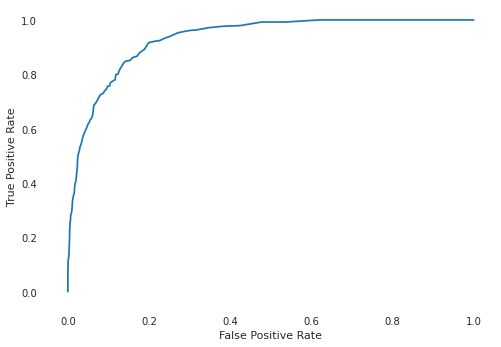

In [93]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [94]:
y_pred_log_model = log_model.predict_proba(X_val)[:, -1]

fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred_log_model)

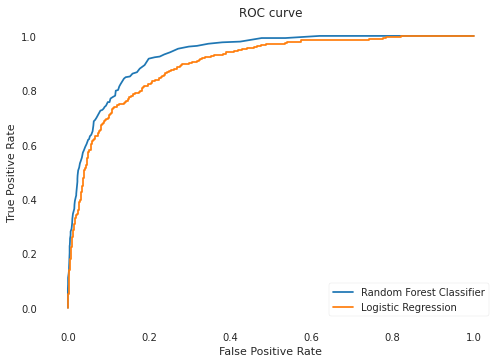

In [97]:
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.plot(fpr2, tpr2, label = 'Logistic Regression')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

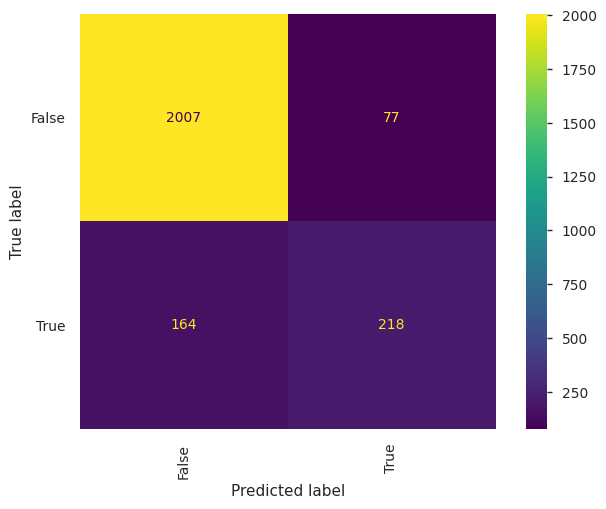

In [101]:
plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(for_model, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [14]:
grad_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    GradientBoostingClassifier()
)

grad_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            crit...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                        

In [15]:
print('Training Accuracy:', grad_model.score(X_train, y_train))
print('Validation Accuracy:', grad_model.score(X_val, y_val))

Training Accuracy: 0.9186942416869425
Validation Accuracy: 0.8990267639902676


In [20]:
operating_systems = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h'}
region = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i'}
browser = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 
           11:'k', 12:'l', 13:'m'}
traffic_type = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 
           11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t'}

In [21]:
new_df = df.copy()

In [23]:
new_df1 = new_df.replace({"Region": region, "Browser": browser, "OperatingSystems": operating_systems, "TrafficType": traffic_type})

In [24]:
new_df1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Returning,Gift
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,a,a,a,a,Returning_Visitor,False,False,True,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,b,b,a,b,Returning_Visitor,False,False,True,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,d,a,i,c,Returning_Visitor,False,False,True,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,c,b,b,d,Returning_Visitor,False,False,True,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,c,c,a,d,Returning_Visitor,True,False,True,False


In [25]:
y1 = new_df1['Revenue']
X1 = new_df1.drop(['Revenue', 'Returning'], axis=1)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.2, stratify=y, random_state=23)

In [27]:
X1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Gift
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,a,a,a,a,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,b,b,a,b,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,d,a,i,c,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,c,b,b,d,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,c,c,a,d,Returning_Visitor,True,False


In [34]:
grad_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=23)
)

grad_model.fit(X1_train, y1_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'OperatingSystems', 'Browser',
                                     'Region', 'TrafficType', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingclass...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=4, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1

In [35]:
print('Training Accuracy:', grad_model.score(X1_train, y1_train))
print('Validation Accuracy:', grad_model.score(X1_val, y1_val))

Training Accuracy: 0.9565085158150851
Validation Accuracy: 0.9018653690186537


In [36]:
y1_pred = grad_model.predict(X1_val)
print(classification_report(y1_val, y1_pred))

              precision    recall  f1-score   support

       False       0.93      0.95      0.94      2084
        True       0.70      0.64      0.67       382

    accuracy                           0.90      2466
   macro avg       0.82      0.79      0.81      2466
weighted avg       0.90      0.90      0.90      2466



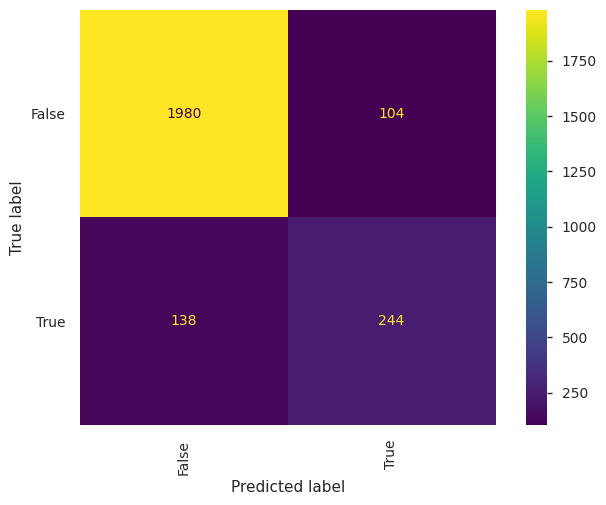

In [37]:
plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(grad_model, X1_val, y1_val, values_format='.0f', xticks_rotation='vertical');

In [40]:
important = grad_model.named_steps['gradientboostingclassifier'].feature_importances_

encoder = grad_model.named_steps['onehotencoder']
encoded_columns = encoder.transform(X1_val).columns

df3 = pd.DataFrame({'encoded_columns':encoded_columns,'feature_importances':important})
df3.sort_values('feature_importances', ascending=False).head(20)

,encoded_columns,feature_importances
8,PageValues,0.634269
5,ProductRelated_Duration,0.053998
6,BounceRates,0.047766
7,ExitRates,0.041703
4,ProductRelated,0.035730
14,Month_Nov,0.033676
1,Administrative_Duration,0.033080
0,Administrative,0.027869
3,Informational_Duration,0.017102
15,Month_May,0.008017


In [30]:
for_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(random_state=23)
)

for_model.fit(X1_train, y1_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'OperatingSystems', 'Browser',
                                     'Region', 'TrafficType', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, s...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                    

In [31]:
print('Training Accuracy:', for_model.score(X1_train, y1_train))
print('Validation Accuracy:', for_model.score(X1_val, y1_val))

Training Accuracy: 1.0
Validation Accuracy: 0.8969991889699919


In [42]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    XGBClassifier(n_estimators=100,
                  random_state=42,
                  n_jobs=-1)
)

pipeline.fit(X1_train, y1_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'OperatingSystems', 'Browser',
                                     'Region', 'TrafficType', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_l

In [43]:
print('Training Accuracy:', pipeline.score(X1_train, y1_train))
print('Validation Accuracy:', pipeline.score(X1_val, y1_val))

Training Accuracy: 0.9176804541768045
Validation Accuracy: 0.902676399026764


In [49]:
pipeline = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RandomForestClassifier(random_state=23)
)

param_distributions = {
    'randomforestclassifier__n_estimators': randint(50, 350),
    'randomforestclassifier__max_depth': [1, 3, 5, 7, 9, None],
    'randomforestclassifier__max_features': uniform(0,1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X1_train, y1_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   49.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
   

In [50]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.8432390117619, 'randomforestclassifier__n_estimators': 154}
Cross-validation accuracy 0.906021897810219


In [52]:
best_pipeline = search.best_estimator_

In [53]:
best_pipeline.fit(X1_val, y1_val)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'OperatingSystems', 'Browser',
                                     'Region', 'TrafficType', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=5,
                                        max_features=0.8432390117619,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
      

In [54]:
print('Training Accuracy:', best_pipeline.score(X1_train, y1_train))
print('Validation Accuracy:', best_pipeline.score(X1_val, y1_val))

Training Accuracy: 0.9014598540145985
Validation Accuracy: 0.9343065693430657


In [55]:
best_y_pred = best_pipeline.predict(X1_val)
print(classification_report(y1_val, best_y_pred))

              precision    recall  f1-score   support

       False       0.95      0.98      0.96      2084
        True       0.84      0.71      0.77       382

    accuracy                           0.93      2466
   macro avg       0.90      0.84      0.87      2466
weighted avg       0.93      0.93      0.93      2466



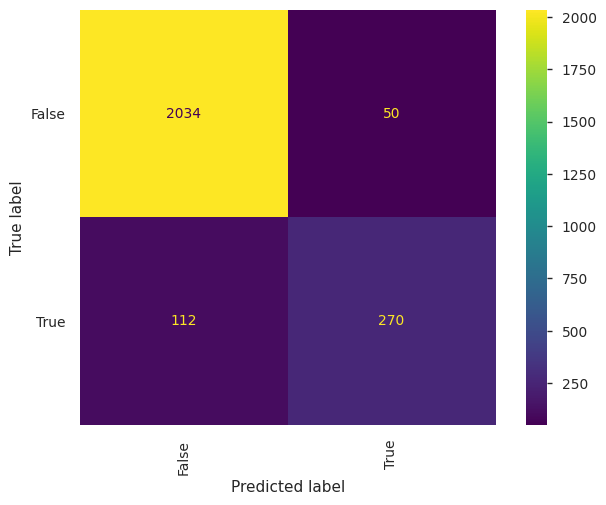

In [56]:
plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(best_pipeline, X1_val, y1_val, values_format='.0f', xticks_rotation='vertical');

In [57]:
df['PageValues'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: PageValues, dtype: float64

In [59]:
df[df['PageValues']!=0]['Revenue'].value_counts()

True     1538
False    1192
Name: Revenue, dtype: int64

In [60]:
nopage = df.copy()
nopage = nopage.drop('PageValues', axis=1)

In [64]:
nopage.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Returning,Gift
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,True,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,True,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,True,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,True,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,True,False


In [65]:
y2 = nopage['Revenue']
X2 = nopage.drop(['Revenue', 'Returning'], axis=1)

In [66]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.2, stratify=y, random_state=23)

In [69]:
y2_train.value_counts(normalize=True)

False    0.845296
True     0.154704
Name: Revenue, dtype: float64

In [72]:
for2_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RandomForestClassifier(random_state=23)
)

param_distributions = {
    'randomforestclassifier__n_estimators': randint(50, 350),
    'randomforestclassifier__max_depth': [1, 3, 5, 7, 9, None],
    'randomforestclassifier__max_features': uniform(0,1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X2_train, y2_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   22.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
   

In [73]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.6570153611673759, 'randomforestclassifier__n_estimators': 121}
Cross-validation accuracy 0.8467153284671532


In [74]:
grad1_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    GradientBoostingClassifier(max_depth=4, n_estimators=250, random_state=23)
)

grad1_model.fit(X2_train, y2_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            crit...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=4, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                        

In [75]:
print('Training Accuracy:', grad1_model.score(X2_train, y2_train))
print('Validation Accuracy:', grad1_model.score(X2_val, y2_val))

Training Accuracy: 0.8953771289537713
Validation Accuracy: 0.8426601784266018


In [77]:
grad_y_pred = grad1_model.predict(X2_val)
print(classification_report(y2_val, grad_y_pred))

              precision    recall  f1-score   support

       False       0.86      0.98      0.91      2084
        True       0.47      0.12      0.18       382

    accuracy                           0.84      2466
   macro avg       0.66      0.55      0.55      2466
weighted avg       0.80      0.84      0.80      2466

